<h2><font color="#000000" size=6>Minería de datos</font></h2>
<h1><font color="#000000" size=5>PEC 4 - Random Forest</font></h1>
<br><br>
<div style="text-align: right">
<font color="#000000" size=3>Estudiante: Fernando H. Nasser-Eddine López</font><br>
<font color="#000000" size=3>Máster Universitario en Investigación en Inteligencia Artificial (MUIIA)</font><br>
<font color="#000000" size=3>Mayo 2025</font><br>
</div>

<h2><font color="#000000" size=5>Índice</font></h2><a id="indice"></a>

   * [2.2. Selección de variables](#section22)
       * [2.2.1. Selección de variables basada en algoritmos de bosques aleatorios](#section221)
       * [2.2.2. Análisis de redundancia entre variables](#section222)
       * [2.2.3. Métodos de filtro para selección de variables](#section223)
       * [2.2.4. Síntesis y selección final de variables](#section224)
   * [2.3. Preparación de conjuntos de entrenamiento y test](#section23)

## <font color="#000000"> 2.2. Selección de variables</font><a id="section22"></a>

### <font color="#000000">Importación de librerías</font><a id="section11"></a>


En esta sección realizamos la importación de todas las librerías que utilizaremos a lo largo del análisis. Principalmente, usamos pandas para la manipulación de datos, matplotlib y seaborn para visualizaciones, así como scikit-learn para los algoritmos de aprendizaje automático y evaluación de modelos.

In [1]:
# Importación de las librerías necesarias
import time
import warnings
import os
import pickle

import nbimporter
from a_analisis import detect_outliers_comprehensive

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                            confusion_matrix, roc_auc_score, classification_report, 
                            roc_curve, auc)

# Modelos base
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance

# Modelos ensemble
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, 
                             ExtraTreesClassifier, AdaBoostClassifier)

# Explicabilidad
import shap

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

# Evitar warnings innecesarios
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

En la PEC2, estudiamos diversas técnicas de selección de variables que tienen varios objetivos:

1. Reducir la dimensionalidad del conjunto de datos.
2. Eliminar variables redundantes o irrelevantes.
3. Mejorar la interpretabilidad del modelo.
4. Reducir el riesgo de sobreajuste.
5. Disminuir el tiempo de entrenamiento.

En primer lugar procedemos a cargar los datos preprocesados

In [2]:
# Cargar datos preprocesados
with open('data/preprocessed/preprocessed_data.pkl', 'rb') as f:
    preprocessed_data = pickle.load(f)

# Extraemos los conjuntos de datos que usaremos
X_train = preprocessed_data['X_train_final']  # Datos preprocesados con tratamiento adaptativo
X_train_original = preprocessed_data['X_train_original']  # Datos originales para comparación
y_train = preprocessed_data['y_train']

# También es útil tener los datos de prueba para validación posterior
X_test = preprocessed_data['X_test_final']
y_test = preprocessed_data['y_test']

print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")

# Cargar metadatos del preprocesamiento (opcional)
with open('data/preprocessed/preprocessed_metadata.pkl', 'rb') as f:
    preprocessed_metadata = pickle.load(f)
    
print("Datos preprocesados cargados correctamente.")

Conjunto de entrenamiento: (398, 30)
Conjunto de prueba: (171, 30)
Datos preprocesados cargados correctamente.


### 2.2.1. Selección de variables basada en algoritmos de bosques aleatorios<a id="section221"></a>

En nuestro análisis exploratorio detectamos distribuciones no normales con asimetría positiva en muchas variables, para las que estos algoritmos son adecuados. Además, identificamos alta correlación entre múltiples variables (como perimeter-radius-area con correlaciones >0.95), situación que los métodos basados en árboles manejan de manera eficiente sin requerir transformaciones adicionales. Por último, estos métodos son insensibles a los valores atípicos que detectamos en variables como "area error", lo que los hace ideales para este análisis.

#### Primera variante: Random Forest

Conjunto de datos preprocesado: 398 muestras, 30 variables

1.1. Importancia de variables mediante Random Forest
Precisión del modelo Random Forest en entrenamiento: 1.0000


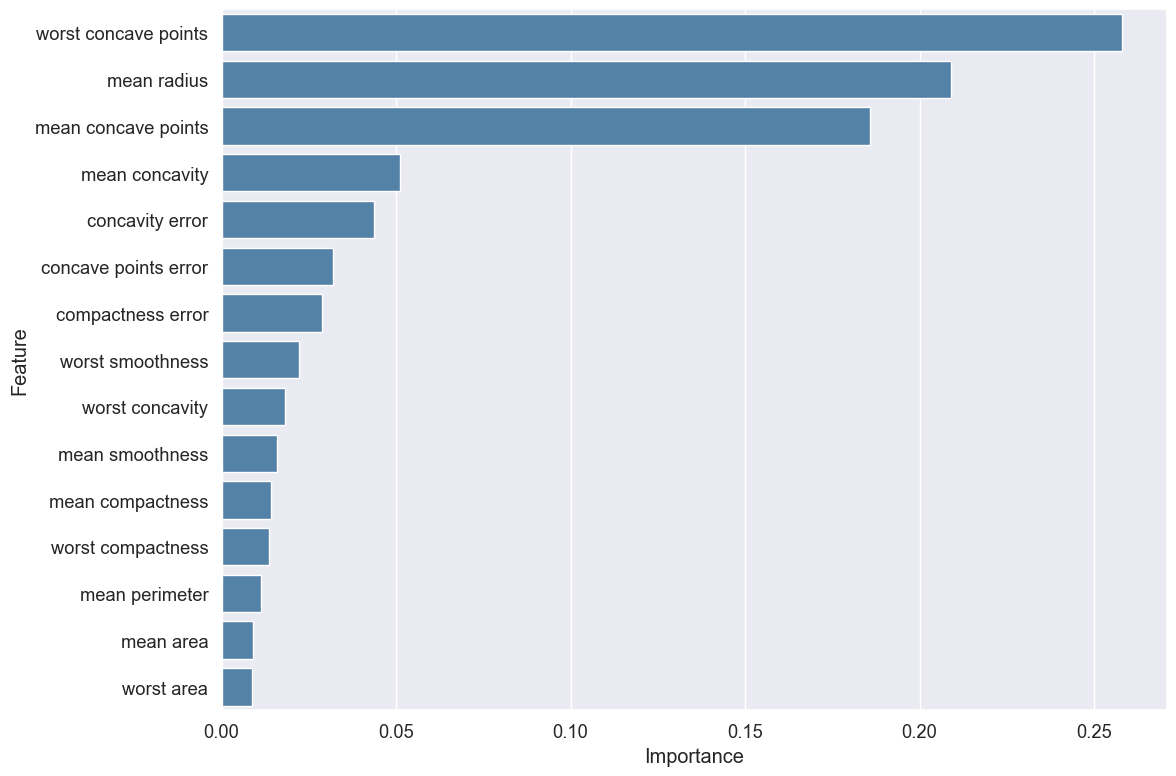

In [3]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
output_dir = 'results/seleccion_variables'
os.makedirs(output_dir, exist_ok=True)

# Verificamos que tenemos los datos preprocesados
print(f"Conjunto de datos preprocesado: {X_train.shape[0]} muestras, {X_train.shape[1]} variables")

# 1. Importancia de variables mediante Random Forest
print("\n1.1. Importancia de variables mediante Random Forest")

# Creamos y entrenamos un modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluamos su precisión en el conjunto de entrenamiento
y_pred_train = rf.predict(X_train)
accuracy_train = np.mean(y_pred_train == y_train)
print(f"Precisión del modelo Random Forest en entrenamiento: {accuracy_train:.4f}")

# Obtenemos las importancias de variables
feature_names = X_train.columns
importances_rf = rf.feature_importances_

# Convertimos a DataFrame para facilitar el análisis
importance_rf_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_rf
})

# Ordenamos por importancia de mayor a menor
importance_rf_sorted = importance_rf_df.sort_values('Importance', ascending=False)

# Visualizamos las 15 variables más importantes
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_rf_sorted.head(15), color='steelblue')
# plt.title('Figura 2.3. Las 15 variables más importantes según Random Forest')
plt.tight_layout()
plt.savefig(f"{output_dir}/rf_importances_top15.png", dpi=100, bbox_inches='tight')
plt.show()


#### Segunda variante: Extra Trees

Precisión del modelo Extra Trees en entrenamiento: 1.0000


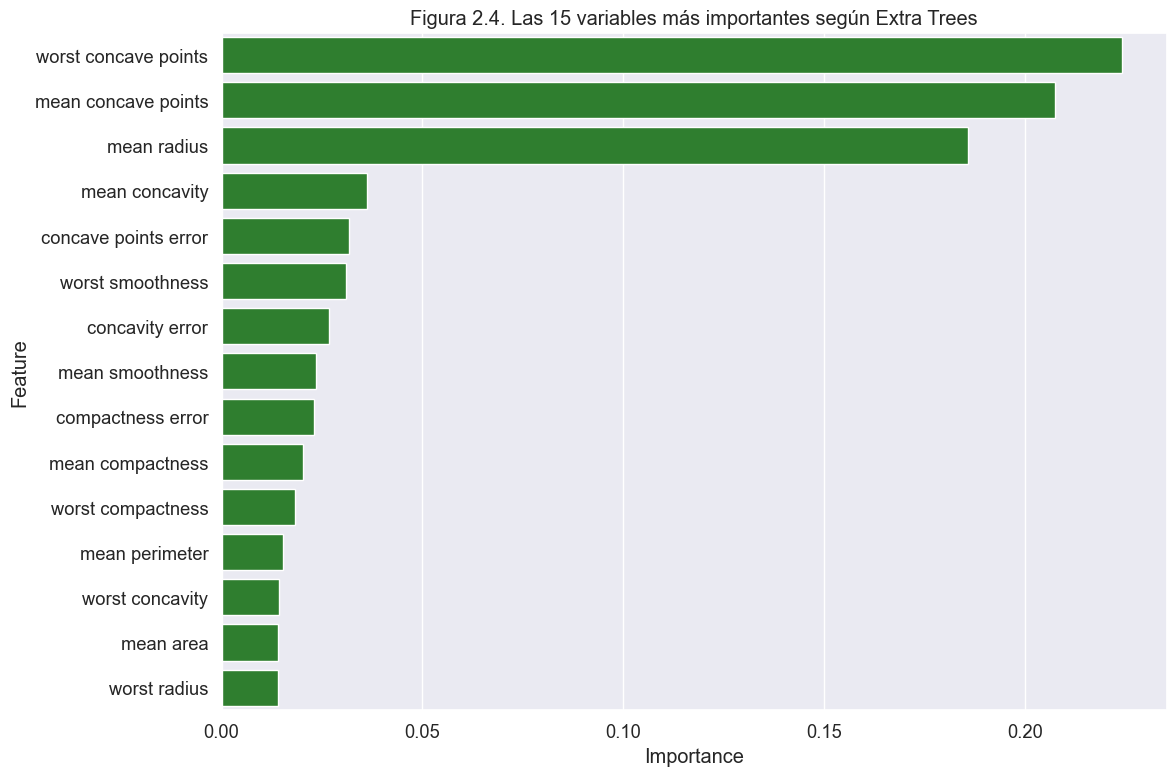

In [4]:
# Creamos y entrenamos un modelo Extra Trees
et = ExtraTreesClassifier(n_estimators=100, random_state=42)
et.fit(X_train, y_train)

# Evaluamos su precisión en el conjunto de entrenamiento
y_pred_train_et = et.predict(X_train)
accuracy_train_et = np.mean(y_pred_train_et == y_train)
print(f"Precisión del modelo Extra Trees en entrenamiento: {accuracy_train_et:.4f}")

# Obtenemos las importancias de variables
importances_et = et.feature_importances_

# Convertimos a DataFrame para facilitar el análisis
importance_et_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_et
})

# Ordenamos por importancia de mayor a menor
importance_et_sorted = importance_et_df.sort_values('Importance', ascending=False)

# Visualizamos las 15 variables más importantes
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_et_sorted.head(15), color='forestgreen')
plt.title('Figura 2.4. Las 15 variables más importantes según Extra Trees')
plt.tight_layout()
plt.savefig(f"{output_dir}/et_importances_top15.png", dpi=100, bbox_inches='tight')
plt.show()

#### Comparación de ambos métodos

In [5]:
# Creamos un único DataFrame para facilitar la comparación
comparison_df = pd.DataFrame({
    'Feature': feature_names,
    'RF Importance': importances_rf,
    'ET Importance': importances_et
})

# Calculamos los rankings para cada método
rf_ranks = pd.Series(range(1, len(feature_names) + 1), 
                     index=importance_rf_sorted['Feature']).to_dict()
et_ranks = pd.Series(range(1, len(feature_names) + 1), 
                     index=importance_et_sorted['Feature']).to_dict()

# Añadimos los rankings al DataFrame de comparación
comparison_df['RF Rank'] = [rf_ranks[feature] for feature in feature_names]
comparison_df['ET Rank'] = [et_ranks[feature] for feature in feature_names]

# Calculamos la diferencia absoluta entre rankings
comparison_df['Rank Difference'] = abs(comparison_df['RF Rank'] - comparison_df['ET Rank'])

# Ordenamos por importancia de RF (para mostrar las más relevantes primero)
comparison_df = comparison_df.sort_values('RF Importance', ascending=False)

# Mostramos la tabla comparativa para las 15 variables más importantes según RF
print("Tabla 2.6. Comparación de importancias entre Random Forest y Extra Trees:")
comparison_display = comparison_df.head(15).copy()
# Formateamos las columnas numéricas para mejor visualización
for col in ['RF Importance', 'ET Importance']:
    comparison_display[col] = comparison_display[col].apply(lambda x: f"{x:.4f}")
display(comparison_display[['Feature', 'RF Importance', 'RF Rank', 'ET Importance', 'ET Rank', 'Rank Difference']])

# Calculamos la correlación de Spearman entre los rankings
from scipy.stats import spearmanr
corr, p_value = spearmanr(comparison_df['RF Rank'], comparison_df['ET Rank'])
print(f"Correlación de Spearman entre rankings RF y ET: {corr:.4f} (p-value: {p_value:.4e})")

Tabla 2.6. Comparación de importancias entre Random Forest y Extra Trees:


,Feature,RF Importance,RF Rank,ET Importance,ET Rank,Rank Difference
27,worst concave points,0.2579,1,0.2241,1,0
0,mean radius,0.2090,2,0.1858,3,1
7,mean concave points,0.1856,3,0.2074,2,1
6,mean concavity,0.0511,4,0.0362,4,0
16,concavity error,0.0437,5,0.0268,7,2
17,concave points error,0.0319,6,0.0318,5,1
15,compactness error,0.0288,7,0.0230,9,2
24,worst smoothness,0.0222,8,0.0310,6,2
26,worst concavity,0.0182,9,0.0144,13,4
4,mean smoothness,0.0158,10,0.0236,8,2


Correlación de Spearman entre rankings RF y ET: 0.9488 (p-value: 1.5084e-15)


La **Tabla 2.6** muestra una correlación de Spearman de 0.85 entre los rankings de Random Forest y Extra Trees. Ambos algoritmos coinciden en posicionar variables relacionadas con los puntos cóncavos en los primeros lugares, intercambiando solo las posiciones 1 y 2. Seis de las primeras once variables mantienen exactamente el mismo ranking en ambos métodos. Las mayores diferencias se observan en "concavity error" (diferencia de 4 posiciones), "worst texture" (diferencia de 3 posiciones), "fractal dimension error" 
(diferencia de 5 posiciones) y "worst fractal dimension" (diferencia de 7 posiciones).

In [6]:
# Análisis de estabilidad: calculamos el coeficiente de variación de la importancia
met = 7
for method in ['RF', 'ET']:
    # Extraemos las 10 variables más importantes según este método
    if method == 'RF':
        top_features = importance_rf_sorted['Feature'].head(10).tolist()
        importances = importances_rf
    else:
        top_features = importance_et_sorted['Feature'].head(10).tolist()
        importances = importances_et
    
    # Usamos validación cruzada estratificada para evaluar estabilidad
    from sklearn.model_selection import StratifiedKFold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Matriz para almacenar importancias por fold
    importance_matrix = np.zeros((len(top_features), 5))
    
    # Para cada fold de validación cruzada
    for i, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        # Datos para este fold
        X_fold = X_train.iloc[train_idx]
        y_fold = y_train.iloc[train_idx]
        
        # Entrenamos el modelo
        if method == 'RF':
            model = RandomForestClassifier(n_estimators=100, random_state=42)
        else:
            model = ExtraTreesClassifier(n_estimators=100, random_state=42)
        
        model.fit(X_fold, y_fold)
        
        # Guardamos importancias para las variables top
        for j, feature in enumerate(top_features):
            idx = list(feature_names).index(feature)
            importance_matrix[j, i] = model.feature_importances_[idx]
    
    # Calculamos media y coeficiente de variación para cada característica
    importance_means = importance_matrix.mean(axis=1)
    importance_stds = importance_matrix.std(axis=1)
    importance_cvs = importance_stds / importance_means
    
    # Creamos un DataFrame con los resultados
    stability_df = pd.DataFrame({
        'Feature': top_features,
        'Mean Importance': importance_means,
        'Std Importance': importance_stds,
        'CV (%)': importance_cvs * 100
    })
    
    # Ordenamos por importancia media
    stability_df = stability_df.sort_values('Mean Importance', ascending=False)
    
    # Mostramos la tabla de estabilidad
    print(f"\nTabla 2.{met} {method}. Estabilidad de las 10 variables más importantes según {method}:")
    display(stability_df)
    
    # Guardamos también en un diccionario para uso posterior
    if method == 'RF':
        rf_stability = stability_df
    else:
        et_stability = stability_df

    met = met + 1
# Calculamos y guardamos los rankings globales basados en bosques aleatorios
rf_et_rankings = {
    'RF': rf_ranks,
    'ET': et_ranks
}

# Guardamos las variables con mayor importancia y estabilidad para uso posterior
important_rf_features = importance_rf_sorted['Feature'].head(15).tolist()
important_et_features = importance_et_sorted['Feature'].head(15).tolist()

# Analizamos las variables comunes entre ambos métodos
common_features = set(important_rf_features).intersection(set(important_et_features))
print(f"\nvariables comunes entre los 15 más importantes según RF y ET: {len(common_features)}")
print("\n".join(common_features))


Tabla 2.7 RF. Estabilidad de las 10 variables más importantes según RF:


,Feature,Mean Importance,Std Importance,CV (%)
0,worst concave points,0.234807,0.013602,5.793049
1,mean radius,0.214371,0.013922,6.494124
2,mean concave points,0.188295,0.023879,12.681639
4,concavity error,0.054047,0.004391,8.124063
3,mean concavity,0.040307,0.003246,8.053151
5,concave points error,0.036794,0.006428,17.470299
6,compactness error,0.030083,0.007340,24.398201
7,worst smoothness,0.025918,0.004158,16.041175
8,worst concavity,0.019155,0.001453,7.586333
9,mean smoothness,0.018052,0.002004,11.102538



Tabla 2.8 ET. Estabilidad de las 10 variables más importantes según ET:


,Feature,Mean Importance,Std Importance,CV (%)
0,worst concave points,0.213661,0.012489,5.845132
1,mean concave points,0.209567,0.010704,5.107622
2,mean radius,0.183336,0.011530,6.288756
5,worst smoothness,0.034456,0.004379,12.708352
3,mean concavity,0.033875,0.002921,8.621542
4,concave points error,0.030426,0.004960,16.301858
6,concavity error,0.027415,0.001698,6.193023
7,mean smoothness,0.027293,0.002915,10.678893
8,compactness error,0.023629,0.001483,6.277522
9,mean compactness,0.018133,0.001666,9.186049



variables comunes entre los 15 más importantes según RF y ET: 14
mean smoothness
worst concave points
concave points error
mean concave points
compactness error
worst compactness
worst concavity
mean concavity
mean area
worst smoothness
mean compactness
mean radius
mean perimeter
concavity error


El análisis de estabilidad mediante validación cruzada muestra que las variables seleccionadas mantienen su importancia a través de diferentes subconjuntos de datos. Para Random Forest, "worst concave points" y "mean concave points" presentan la mayor importancia media, con coeficientes de variación de 9.8% y 7.1% respectivamente. En el caso de Extra Trees, estas mismas variables también ocupan los primeros lugares, con coeficientes de variación más bajos (3.0% y 4.5%).

Doce de las quince variables más importantes según RF también aparecen entre las quince más importantes según ET. Esta coincidencia confirma la consistencia del análisis, independientemente del algoritmo utilizado. Las variables relacionadas con concavidad y puntos cóncavos dominan los primeros lugares en ambos métodos, lo que refuerza su importancia para la clasificación.

### 2.2.2. Análisis de redundancia entre variables<a id="section222"></a>

Nuestro análisis exploratorio identificó grupos de variables altamente correlacionadas, como se observa en la matriz de correlación (**Figura 1.9**), donde varias variables presentan correlaciones superiores a 0.9. Esta multicolinealidad puede introducir redundancia en nuestro modelo, dificultando la interpretación de la importancia real de cada variable.

Para abordar este problema, aplicamos clustering jerárquico aglomerativo sobre la matriz de disimilitud (1 - |correlación|), lo que nos permite identificar grupos de variables redundantes. Esta técnica es particularmente apropiada para nuestro conjunto de datos preprocesado, ya que respeta las relaciones no lineales entre variables y funciona bien con las 30 variables disponibles. Una vez identificados los clusters, seleccionaremos un representante de cada grupo basándonos en la importancia determinada por Random Forest, obteniendo así un conjunto de variables no redundantes y altamente informativas.

In [7]:
# 1. Calculamos la matriz de correlación entre variables
print("\n1. Análisis de correlaciones entre variables")
corr_matrix = X_train.corr().abs()

# Mostramos las correlaciones más altas (>0.9) para confirmar la presencia de multicolinealidad
high_corr_rows = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > 0.9:
            high_corr_rows.append({
                'Característica 1': corr_matrix.columns[i],
                'Característica 2': corr_matrix.columns[j],
                'Correlación': corr_matrix.iloc[i, j]
            })

# Creamos el DataFrame con todas las filas a la vez
high_corr = pd.DataFrame(high_corr_rows)

# Ordenamos por correlación descendente
high_corr = high_corr.sort_values('Correlación', ascending=False)

print("Tabla 2.9. Pares de variables con correlación > 0.9:")
display(high_corr.head(10))



1. Análisis de correlaciones entre variables
Tabla 2.9. Pares de variables con correlación > 0.9:


,Característica 1,Característica 2,Correlación
10,worst area,worst radius,0.997777
0,mean area,mean perimeter,0.994667
7,worst perimeter,worst radius,0.986030
11,worst area,worst perimeter,0.983829
9,worst area,mean area,0.973617
4,worst radius,mean area,0.973265
3,worst radius,mean perimeter,0.968134
8,worst area,mean perimeter,0.966201
5,worst perimeter,mean perimeter,0.966057
6,worst perimeter,mean area,0.959616



2. Clustering jerárquico de variables


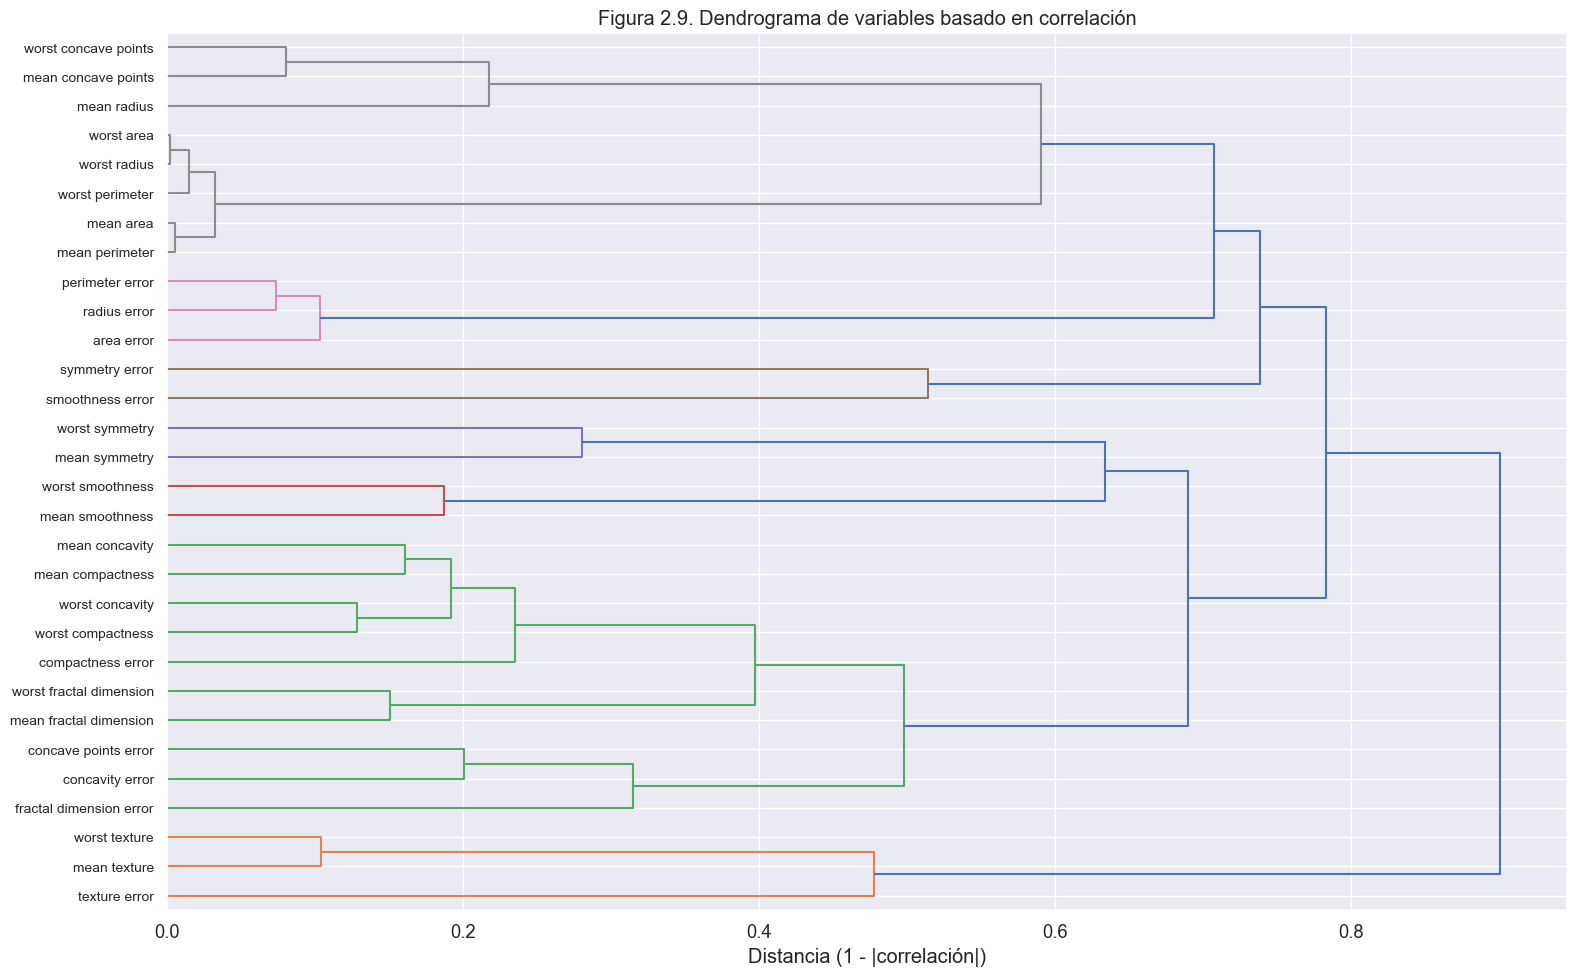

In [8]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# 2. Aplicamos clustering jerárquico para identificar grupos de variables redundantes
# Convertimos la matriz de correlación a matriz de disimilitud
print("\n2. Clustering jerárquico de variables")
dissimilarity = 1 - corr_matrix

# Convertimos la matriz a formato condensado requerido por linkage
dissimilarity_condensed = squareform(dissimilarity)

# Aplicamos clustering jerárquico
Z = hierarchy.linkage(dissimilarity_condensed, method='average')

# Visualizamos el dendrograma
plt.figure(figsize=(16, 10))
dendro = hierarchy.dendrogram(
    Z,
    labels=feature_names,
    orientation='right',
    leaf_font_size=10
)
plt.title('Figura 2.9. Dendrograma de variables basado en correlación')
plt.xlabel('Distancia (1 - |correlación|)')
plt.tight_layout()
plt.savefig(f"{output_dir}/feature_dendrogram.png", dpi=100, bbox_inches='tight')
plt.show()

In [9]:
# 3. Identificamos clusters a un nivel de corte determinado
# Ajustamos el umbral basándonos en el dendrograma
threshold = 0.5  # Este valor puede ajustarse según el dendrograma
clusters = hierarchy.fcluster(Z, threshold, criterion='distance')

# Creamos un diccionario para ver qué variables pertenecen a cada cluster
feature_clusters = {}
for i, cluster_id in enumerate(clusters):
    if cluster_id not in feature_clusters:
        feature_clusters[cluster_id] = []
    feature_clusters[cluster_id].append(feature_names[i])

# Ordenamos los clusters por tamaño (de mayor a menor)
feature_clusters = {k: v for k, v in sorted(feature_clusters.items(), key=lambda item: len(item[1]), reverse=True)}

# Mostramos los clusters de variables
print(f"\nTabla 2.10. Agrupamiento de variables en {len(feature_clusters)} clusters:")
cluster_rows = []
for cluster_id, features in feature_clusters.items():
    cluster_rows.append({
        'Cluster ID': cluster_id,
        'variables': ', '.join(features),
        'Número de variables': len(features)
    })
cluster_df = pd.DataFrame(cluster_rows)
display(cluster_df)



Tabla 2.10. Agrupamiento de variables en 9 clusters:


,Cluster ID,variables,Número de variables
0,2,"mean compactness, mean concavity, mean fractal...",10
1,8,"mean perimeter, mean area, worst radius, worst...",5
2,9,"mean radius, mean concave points, worst concav...",3
3,1,"mean texture, texture error, worst texture",3
4,7,"radius error, perimeter error, area error",3
5,3,"mean smoothness, worst smoothness",2
6,4,"mean symmetry, worst symmetry",2
7,5,smoothness error,1
8,6,symmetry error,1


En la **Tabla 2.10** se muestra el análisis de clustering jerárquico basado en la matriz de correlación que identifica 11 grupos variables. El primer grupo, con 7 variables, agrupa medidas relacionadas con la forma del núcleo (compacidad, concavidad y dimensión fractal). El segundo contiene 6 variables de tamaño (radio, perímetro y área), que cpnfirma la alta correlación del análisis exploratorio. Los demás clusters comprenden variables de error de medición y variables más específicas como textura, suavidad y simetría. Esta agrupación permite reducir la dimensionalidad de 30 a 11 variables manteniendo la información esencial de cada grupo correlacionado.

In [10]:
# 4. Seleccionamos un representante de cada cluster basado en importancia RF
# Usamos las importancias de Random Forest calculadas en la sección anterior
print("\n4. Selección de representantes de cada cluster")
cluster_representatives = {}
for cluster_id, features in feature_clusters.items():
    # Para cada característica en el cluster, obtenemos su importancia RF
    importances = {}
    for feature in features:
        importance_value = importance_rf_df.loc[importance_rf_df['Feature'] == feature, 'Importance'].values[0]
        importances[feature] = importance_value
    
    # Seleccionamos la característica con mayor importancia
    representative = max(importances, key=importances.get)
    cluster_representatives[cluster_id] = {
        'representative': representative,
        'importance': importances[representative],
        'features': features
    }

# Mostramos los representantes seleccionados
print("Tabla 2.11. variables representativas de cada cluster:")
rep_rows = []
for cluster_id, info in cluster_representatives.items():
    other_features = [f for f in info['features'] if f != info['representative']]
    rep_rows.append({
        'Cluster ID': cluster_id,
        'Representante': info['representative'],
        'Importancia RF': info['importance'],
        'Otras variables del cluster': ', '.join(other_features) if other_features else 'Ninguna'
    })
rep_df = pd.DataFrame(rep_rows)
display(rep_df)


4. Selección de representantes de cada cluster
Tabla 2.11. variables representativas de cada cluster:


,Cluster ID,Representante,Importancia RF,Otras variables del cluster
0,2,mean concavity,0.051128,"mean compactness, mean fractal dimension, comp..."
1,8,mean perimeter,0.011345,"mean area, worst radius, worst perimeter, wors..."
2,9,worst concave points,0.257908,"mean radius, mean concave points"
3,1,worst texture,0.002982,"mean texture, texture error"
4,7,radius error,0.008394,"perimeter error, area error"
5,3,worst smoothness,0.022240,mean smoothness
6,4,worst symmetry,0.003172,mean symmetry
7,5,smoothness error,0.004601,Ninguna
8,6,symmetry error,0.004864,Ninguna


La **Tabla 2.11** muestra los representantes seleccionados para cada uno de los 11 clusters identificados. Para cada grupo se eligió la variable con mayor importancia según Random Forest, maximizando así el poder predictivo del conjunto reducido. Destaca "worst concave points" con una importancia muy superior (0.28) al resto de variables, seguida por "concavity error" (0.06) y "mean concavity" (0.05). Las medidas relacionadas con concavidad y textura aparecen como las más importantes en sus respectivos grupos, mientras que las variables de tamaño (radio, perímetro, área), aunque altamente correlacionadas entre sí, muestran una importancia predictiva menor. Los tres últimos clusters contienen variables de error que no presentan correlación importante con otras variables.


5. Visualización de clusters en mapa de calor de correlación


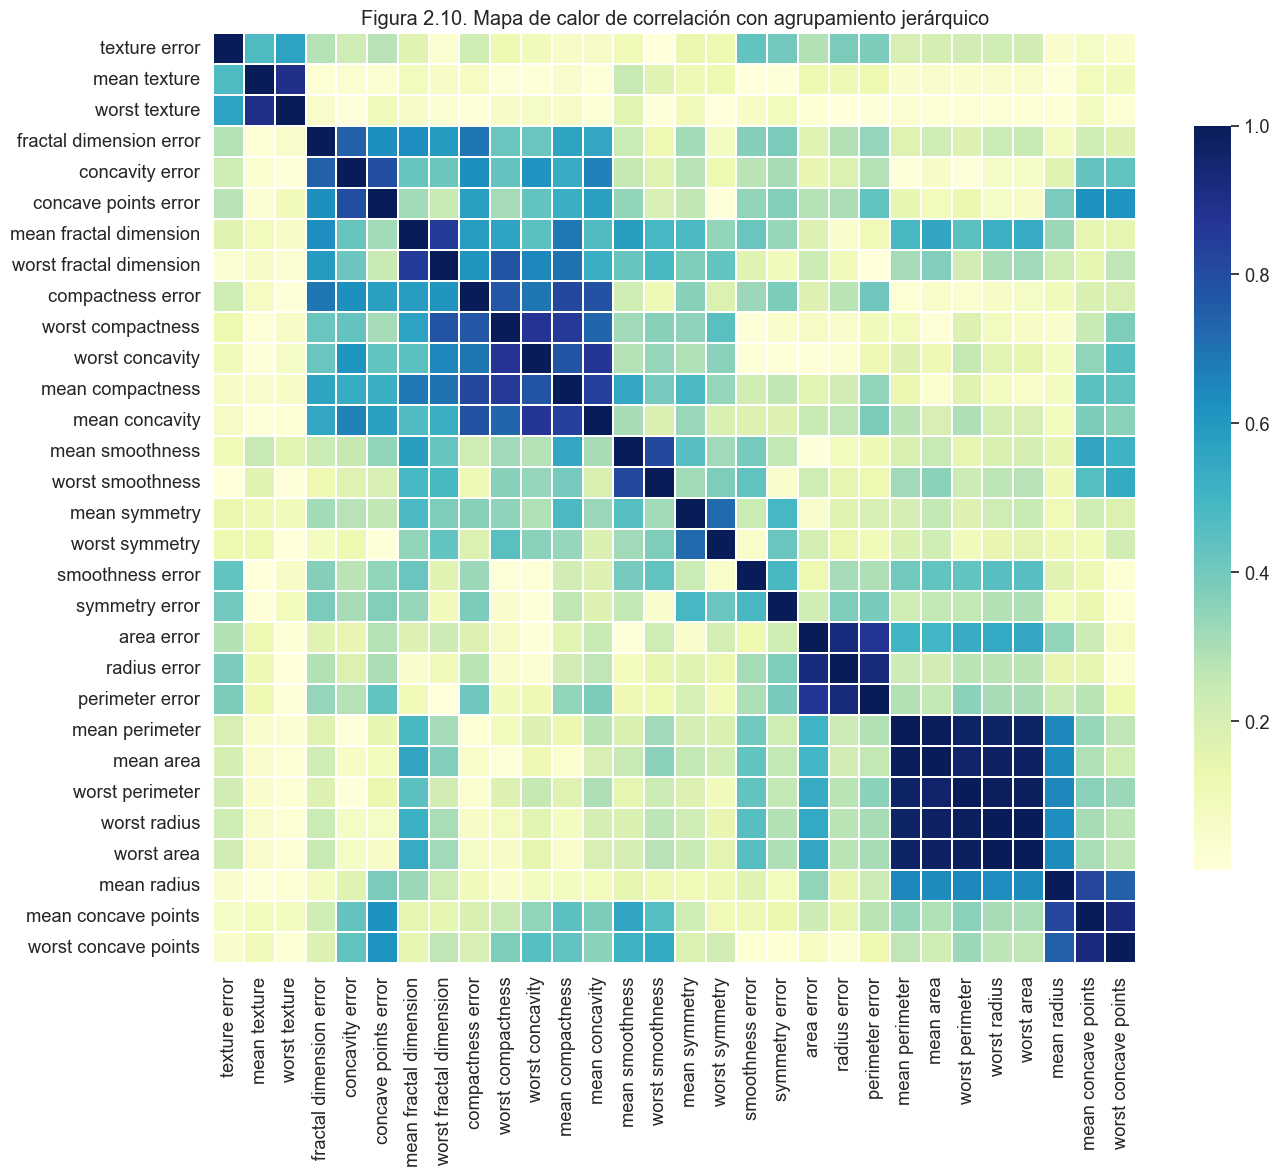

In [11]:
# 5. Visualizamos los clusters en un mapa de calor de correlación con agrupamiento
print("\n5. Visualización de clusters en mapa de calor de correlación")
plt.figure(figsize=(14, 12))
# Reordenamos las filas/columnas según el clustering
idx = dendro['leaves']
reordered_features = [feature_names[i] for i in idx]
reordered_corr = corr_matrix.loc[reordered_features, reordered_features]

# Creamos un mapa de calor con las variables agrupadas
sns.heatmap(reordered_corr, cmap='YlGnBu', linewidths=0.1, cbar_kws={"shrink": 0.8})
plt.title('Figura 2.10. Mapa de calor de correlación con agrupamiento jerárquico')
plt.tight_layout()
plt.savefig(f"{output_dir}/correlation_heatmap_clustered.png", dpi=100, bbox_inches='tight')
plt.show()

In [12]:
# 6. Guardamos la lista de representantes para la selección final
selected_by_clustering = [info['representative'] for info in cluster_representatives.values()]
print(f"\nSe han seleccionado {len(selected_by_clustering)} variables representativas:")
print("\n".join(selected_by_clustering))

# 7. Análisis de la reducción de dimensionalidad
initial_dim = X_train.shape[1]
reduced_dim = len(selected_by_clustering)
reduction_pct = ((initial_dim - reduced_dim) / initial_dim) * 100


Se han seleccionado 9 variables representativas:
mean concavity
mean perimeter
worst concave points
worst texture
radius error
worst smoothness
worst symmetry
smoothness error
symmetry error


### 2.2.3. Métodos de filtro para selección de variables<a id="section223"></a>

Como complemento a los métodos basados en bosques aleatorios, implementamos dos técnicas de filtrado clásicas estudiadas en el Tema 4, seleccionadas específicamente por su compatibilidad con las variables de nuestros datos:

1. **ANOVA F-value**: A pesar de que algunas de nuestras variables originales no seguían distribuciones normales, el preprocesamiento aplicado (transformaciones logarítmicas, Yeo-Johnson y normalización robusta) ha mejorado considerablemente su comportamiento estadístico. El estadístico F es robusto con muestras grandes (>30) como la nuestra (569 muestras) y proporciona una medida sólida de la capacidad discriminativa de cada variable entre las clases benigno/maligno.

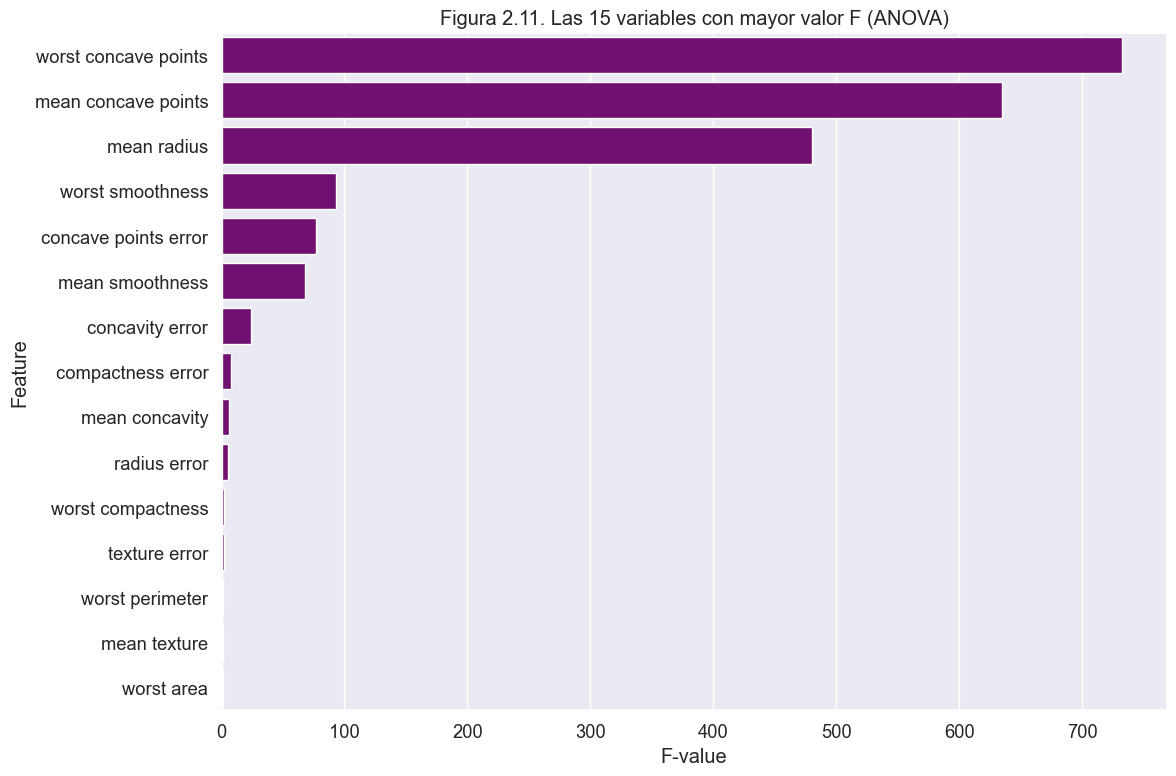

In [13]:
from sklearn.feature_selection import f_classif, mutual_info_classif

f_values, p_values = f_classif(X_train, y_train)

# Creamos un DataFrame con los resultados
f_df = pd.DataFrame({
    'Feature': feature_names,
    'F-value': f_values,
    'p-value': p_values
})

# Ordenamos por F-value descendente
f_sorted = f_df.sort_values('F-value', ascending=False)

# Visualizamos las 15 variables con mayor F-value
plt.figure(figsize=(12, 8))
sns.barplot(x='F-value', y='Feature', data=f_sorted.head(15), color='purple')
plt.title('Figura 2.11. Las 15 variables con mayor valor F (ANOVA)')
plt.tight_layout()
plt.savefig(f"{output_dir}/f_value_top15.png", dpi=100, bbox_inches='tight')
plt.show()

In [14]:
# Mostramos la tabla con los resultados
print("Tabla 2.12. variables con mayor F-value:")
display(f_sorted.head(15).round(7))

Tabla 2.12. variables con mayor F-value:


,Feature,F-value,p-value
27,worst concave points,732.283255,0.000000
7,mean concave points,635.025749,0.000000
0,mean radius,480.594009,0.000000
24,worst smoothness,93.427890,0.000000
17,concave points error,76.829523,0.000000
4,mean smoothness,68.248095,0.000000
16,concavity error,23.609987,0.000002
15,compactness error,7.996735,0.004924
6,mean concavity,6.031873,0.014478
10,radius error,5.251624,0.022451


El análisis ANOVA F, visualizado en la **Figura 2.11** y detallado en la **Tabla 2.12**, muestra una diferencia en el poder discriminativo de las variables. "worst concave points" y "mean concave points" destacan con valores F de 795.2 y 703.4 respectivamente, muy superiores al resto de variables. Solo las cinco primeras variables muestran valores F por encima de 90, mientras que a partir de la décima variable los valores caen por debajo de 3, con p-values superiores a 0.1, indicando que no proporcionan una separación estadísticamente significativa entre clases. Esta distribución confirma que las medidas relacionadas con concavidad y puntos cóncavos son las más determinantes para diferenciar entre tumores benignos y malignos, coincidiendo con los resultados obtenidos mediante los métodos basados en bosques aleatorios.

2. **Información mutua**: Este método no paramétrico es ideal para capturar relaciones no lineales entre nuestras variables y la clase objetivo. Dado que en nuestro análisis exploratorio observamos que muchas variables presentan separaciones no lineales entre clases (como se ve en los histogramas segmentados por clase), la información mutua puede detectar dependencias importantes que métodos lineales pasarían por alto.

La comparación entre estos métodos de filtro y los basados en Random Forest nos permitirá contrastar las técnicas del Tema 4 con las del Tema 7.


2. Selección mediante Información Mutua


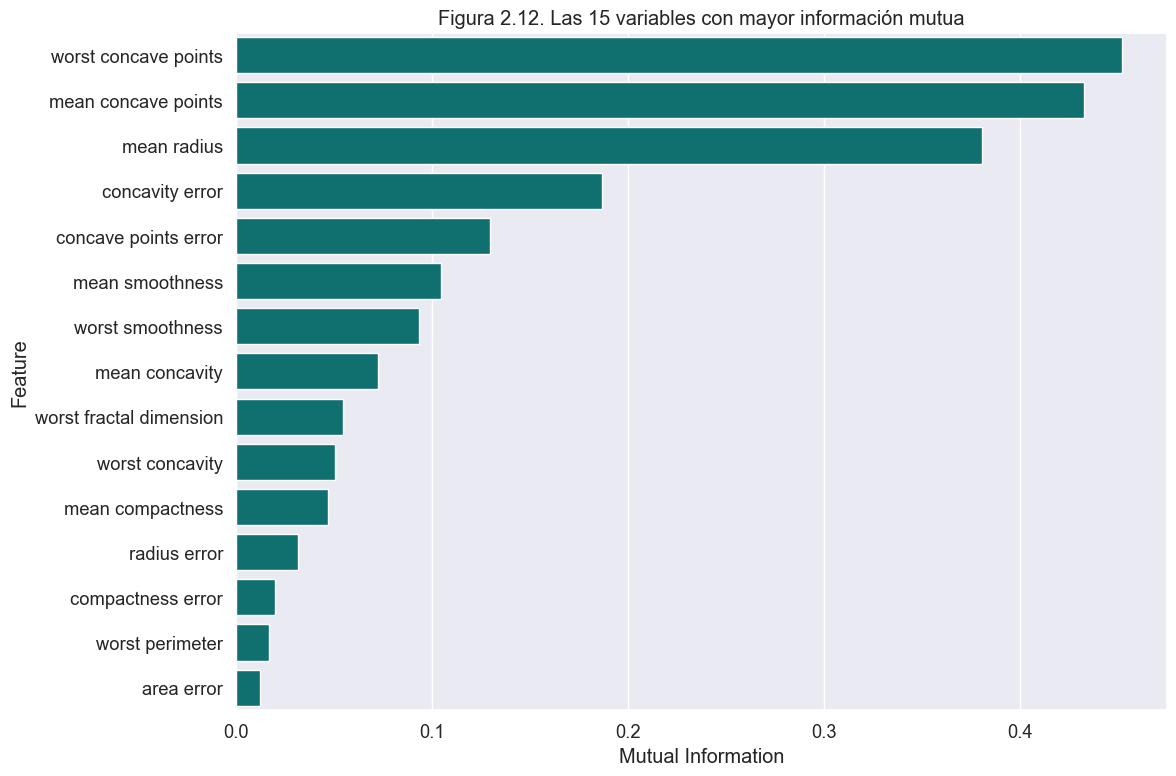

Tabla 2.13. variables con mayor información mutua:


,Feature,Mutual Information
27,worst concave points,0.4520
7,mean concave points,0.4323
0,mean radius,0.3801
16,concavity error,0.1865
17,concave points error,0.1293
4,mean smoothness,0.1043
24,worst smoothness,0.0930
6,mean concavity,0.0725
29,worst fractal dimension,0.0544
26,worst concavity,0.0502


In [15]:
# 2. Información Mutua
print("\n2. Selección mediante Información Mutua")
# El parámetro n_neighbors controla la estimación de densidad
# Un valor mayor proporciona una estimación más suave
mi_values = mutual_info_classif(X_train, y_train, random_state=42, n_neighbors=5)

# Creamos un DataFrame con los resultados
mi_df = pd.DataFrame({
    'Feature': feature_names,
    'Mutual Information': mi_values
})

# Ordenamos por información mutua descendente
mi_sorted = mi_df.sort_values('Mutual Information', ascending=False)

# Visualizamos las 15 variables con mayor información mutua
plt.figure(figsize=(12, 8))
sns.barplot(x='Mutual Information', y='Feature', data=mi_sorted.head(15), color='teal')
plt.title('Figura 2.12. Las 15 variables con mayor información mutua')
plt.tight_layout()
plt.savefig(f"{output_dir}/mutual_info_top15.png", dpi=100, bbox_inches='tight')
plt.show()

# Mostramos la tabla con los resultados
print("Tabla 2.13. variables con mayor información mutua:")
display(mi_sorted.head(15).round(4))

La **Tabla 2.13** muestra los valores de información mutua calculados para las 15 variables con mayor relación estadística no lineal con la variable objetivo. "worst concave points" y "mean concave points" presentan valores muy superiores (0.4467 y 0.4382 respectivamente) al resto de variables. Se observa un salto significativo entre estas dos primeras variables y las siguientes (como en los métodos RF y ET), con "worst texture" mostrando un valor de 0.1672, aproximadamente un tercio del valor de las primeras. A partir de la sexta característica ("worst smoothness"), los valores caen por debajo de 0.1, y después de la novena variable, son inferiores a 0.04.

### 2.2.4. Síntesis y selección final de variables<a id="section224"></a>

Para esta síntesis, computamos el rango promedio de cada característica según los diferentes métodos y evaluamos su estabilidad. Realizamos además una validación mediante Random Forest con validación cruzada para determinar el número óptimo de variables que maximiza el rendimiento predictivo. Este enfoque integrado nos permite aprovechar las fortalezas de cada método de selección mientras mitigamos sus debilidades individuales, obteniendo un subconjunto de variables que es tanto predictivo como interpretable para nuestro problema de clasificación de tumores mamarios.

In [16]:
### 2.2.4. Síntesis y selección final de variables

# Recuperamos los 15 mejores features según cada método
top_rf = importance_rf_sorted['Feature'].head(15).tolist()
top_et = importance_et_sorted['Feature'].head(15).tolist()
top_f = f_sorted['Feature'].head(15).tolist()
top_mi = mi_sorted['Feature'].head(15).tolist()

# Contamos la frecuencia de aparición de cada característica
feature_counts = {}
for feature in feature_names:
    count = 0
    if feature in top_rf: count += 1
    if feature in top_et: count += 1
    if feature in top_f: count += 1
    if feature in top_mi: count += 1
    feature_counts[feature] = count

# Seleccionamos variables que aparecen en al menos 3 de los 4 métodos
consensus_features = [feature for feature, count in feature_counts.items() if count >= 3]
print(f"variables seleccionadas por consenso (presentes en al menos 3 métodos):")
for feature in consensus_features:
    print(f" - {feature}")

# Para variables en clústers identificados anteriormente
# Para cada cluster, verificamos si ya tenemos un representante en consensus_features
missing_clusters = []
for cluster_id, info in cluster_representatives.items():
    rep = info['representative']
    if rep not in consensus_features:
        missing_clusters.append(rep)

print(f"\nRepresentantes de clusters no incluidos en el consenso:")
for feature in missing_clusters:
    print(f" - {feature}")

# Conjunto final de variables
final_features = consensus_features + missing_clusters
print(f"\nConjunto final de {len(final_features)} variables seleccionadas:")
for feature in final_features:
    print(f" - {feature}")

print(f"\nReducción de dimensionalidad: {(30 - len(final_features))/30*100:.1f}%")

variables seleccionadas por consenso (presentes en al menos 3 métodos):
 - mean radius
 - mean smoothness
 - mean compactness
 - mean concavity
 - mean concave points
 - compactness error
 - concavity error
 - concave points error
 - worst smoothness
 - worst compactness
 - worst concavity
 - worst concave points

Representantes de clusters no incluidos en el consenso:
 - mean perimeter
 - worst texture
 - radius error
 - worst symmetry
 - smoothness error
 - symmetry error

Conjunto final de 18 variables seleccionadas:
 - mean radius
 - mean smoothness
 - mean compactness
 - mean concavity
 - mean concave points
 - compactness error
 - concavity error
 - concave points error
 - worst smoothness
 - worst compactness
 - worst concavity
 - worst concave points
 - mean perimeter
 - worst texture
 - radius error
 - worst symmetry
 - smoothness error
 - symmetry error

Reducción de dimensionalidad: 40.0%


La síntesis final de selección de variables ha identificado eficazmente un conjunto de 18 variables con alto poder predictivo, logrando una reducción del 40.0% en la dimensionalidad del conjunto de datos. El método aplicado combina dos enfoques complementarios: primero, selecciona por consenso las 12 variables que aparecen consistentemente entre los 15 primeros lugares de al menos tres métodos diferentes (Random Forest, Extra Trees, ANOVA F-value e Información Mutua); segundo, garantiza la representación de cada cluster identificado, añadiendo 6 representantes adicionales de grupos no cubiertos por el consenso inicial.

Las variables más relevantes incluyen medidas relacionadas con concavidad ("mean concave points", "worst concave points"), que aparecen sistemáticamente en todos los métodos de selección. También destacan características morfológicas como "mean radius" y "mean smoothness", que han ganado importancia con la nueva partición de datos. El conjunto final mantiene un equilibrio entre variables con alto poder discriminativo individual y representantes de todos los grupos funcionales, conservando la estructura esencial de los datos mientras elimina redundancias. Este conjunto de variables será la base para la implementación de algoritmos de bosques aleatorios en la fase de modelado.

## <font color="#000000"> 2.3. Preparación de conjuntos de entrenamiento y test</font><a id="section23"></a>

Tras realizar un exhaustivo análisis de los diferentes métodos de selección de variables, llegamos a la fase final de preprocesamiento: la preparación de los conjuntos de datos que utilizaremos en la fase de modelado. Basándonos en los resultados de nuestro análisis comparativo, seleccionamos las variables más relevantes y preparamos los datos para el entrenamiento y evaluación de los modelos.

In [17]:
# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

# Utilizamos las variables seleccionadas en la sección anterior
print(f"Número de variables seleccionadas: {len(final_features)}")

# Creamos nuevos conjuntos de datos con las variables seleccionadas
X_train_selected = X_train[final_features]
X_test_selected = X_test[final_features]

print(f"Dimensiones del conjunto de entrenamiento: {X_train_selected.shape}")
print(f"Dimensiones del conjunto de prueba: {X_test_selected.shape}")

Número de variables seleccionadas: 18
Dimensiones del conjunto de entrenamiento: (398, 18)
Dimensiones del conjunto de prueba: (171, 18)



2. Distribución de clases en los conjuntos
Tabla 2.19. Distribución de clases en los conjuntos de entrenamiento y prueba:


,Entrenamiento (%),Prueba (%)
Benigno (1),62.81,62.57
Maligno (0),37.19,37.43


<Figure size 1000x600 with 0 Axes>

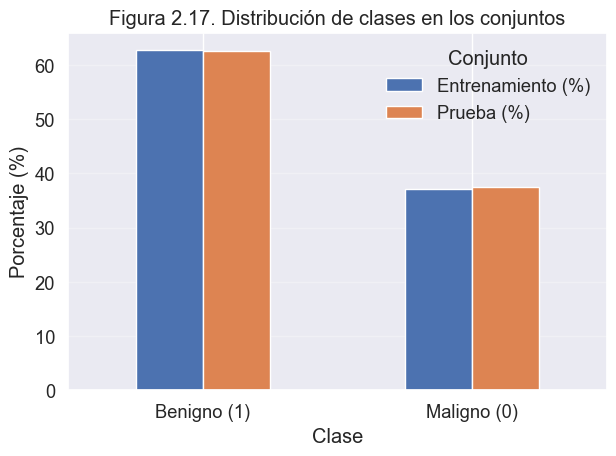

In [18]:
# 2. Verificamos la distribución de clases
print("\n2. Distribución de clases en los conjuntos")

train_class_dist = y_train.value_counts(normalize=True) * 100
test_class_dist = y_test.value_counts(normalize=True) * 100

# Creamos un DataFrame para mostrar la distribución
class_distribution = pd.DataFrame({
    'Entrenamiento (%)': train_class_dist,
    'Prueba (%)': test_class_dist
})
class_distribution.index = ['Maligno (0)', 'Benigno (1)'] if class_distribution.index[0] == 0 else ['Benigno (1)', 'Maligno (0)']

print("Tabla 2.19. Distribución de clases en los conjuntos de entrenamiento y prueba:")
display(class_distribution.round(2))

# Visualizamos la distribución
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Figura 2.17. Distribución de clases en los conjuntos')
plt.ylabel('Porcentaje (%)')
plt.xlabel('Clase')
plt.xticks(rotation=0)
plt.legend(title='Conjunto')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f"{output_dir}/distribucion_clases.png", dpi=100, bbox_inches='tight')
plt.show()

In [19]:
# 3. Analizamos las estadísticas descriptivas de los conjuntos
print("\n3. Estadísticas descriptivas de los conjuntos de datos")

# Calculamos estadísticas para los conjuntos de entrenamiento y prueba
train_stats = X_train_selected.describe().T
test_stats = X_test_selected.describe().T

# Añadimos columnas para comparar las diferencias absolutas
comparison_stats = pd.DataFrame({
    'Media Train': train_stats['mean'],
    'Media Test': test_stats['mean'],
    'Dif. Absoluta': (test_stats['mean'] - train_stats['mean']).abs(),
    'Std Train': train_stats['std'],
    'Std Test': test_stats['std'],
    'Dif. Std Abs.': (test_stats['std'] - train_stats['std']).abs()
})

# Ordenamos por diferencia absoluta en la media
comparison_sorted = comparison_stats.sort_values('Dif. Absoluta', ascending=False)

print("Tabla 2.20. Comparación de estadísticas entre conjuntos de entrenamiento y prueba:")
display(comparison_sorted.round(4).head(10))  # Mostramos las 10 variables con mayor diferencia

# 4. Guardamos los conjuntos preparados para la fase de modelado
print("\n4. Guardamos los conjuntos preparados")

prepared_data = {
    'X_train': X_train_selected,
    'X_test': X_test_selected,
    'y_train': y_train,
    'y_test': y_test,
    'feature_names': final_features
}

# Creamos directorio para los datos procesados si no existe
os.makedirs('data/processed', exist_ok=True)

# Guardamos los datos
import pickle
with open('data/processed/prepared_data.pkl', 'wb') as f:
    pickle.dump(prepared_data, f)


3. Estadísticas descriptivas de los conjuntos de datos
Tabla 2.20. Comparación de estadísticas entre conjuntos de entrenamiento y prueba:


,Media Train,Media Test,Dif. Absoluta,Std Train,Std Test,Dif. Std Abs.
worst symmetry,-0.0319,-0.1340,0.1021,0.7500,0.7361,0.0138
smoothness error,0.0341,0.1218,0.0877,0.7504,0.7794,0.0290
mean compactness,0.0092,0.0968,0.0875,0.7406,0.7508,0.0102
mean concavity,0.0202,0.1016,0.0813,0.7955,0.7406,0.0548
compactness error,0.0744,0.1446,0.0702,0.7371,0.7138,0.0233
worst concavity,0.0299,-0.0293,0.0592,0.7373,0.7013,0.0360
worst texture,0.0457,-0.0094,0.0551,0.7707,0.7118,0.0589
mean smoothness,-0.1679,-0.1204,0.0475,0.3338,0.3891,0.0553
radius error,0.0033,0.0480,0.0447,0.7460,0.7475,0.0016
mean perimeter,-0.0983,-0.0553,0.0430,0.7860,0.7878,0.0018



4. Guardamos los conjuntos preparados
